In [1]:
# # Bibliotheken installieren
# !uv pip install transformers sentence-transformers scikit-learn matplotlib plotly numpy pandas tqdm

# # Bibliotheken importieren
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.decomposition import PCA
# import plotly.express as px
# import plotly.graph_objects as go
# from transformers import AutoTokenizer, AutoModel
# from sentence_transformers import SentenceTransformer
# import torch
# import pandas as pd
# from collections import Counter
# import re
# from tqdm.auto import tqdm

# Bibliotheken installieren (erweitert mit nbformat und anderen wichtigen Abhängigkeiten)
!pip install transformers sentence-transformers scikit-learn matplotlib plotly numpy pandas tqdm
!pip install nbformat>=4.2.0 ipywidgets>=7.0.0 jupyter_client>=5.0.0 jupyterlab
!pip install --upgrade notebook

# Möglicherweise ist ein Neustart des Kernels erforderlich nach diesen Installationen
# Nach dem Ausführen dieser Zelle: Kernel -> Restart & Clear Output -> Run All

# Bibliotheken importieren
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
from transformers import AutoTokenizer, AutoModel
from sentence_transformers import SentenceTransformer
import torch
import pandas as pd
from collections import Counter
import re
from tqdm.auto import tqdm

zsh:1: 4.2.0 not found


/Users/daniel/projects/text2sql_eval/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def preprocess_text(text):
    # Text in Absätze/Sätze aufteilen für Sentence-Level Embeddings
    paragraphs = text.split('\n')
    sentences = []
    
    for paragraph in paragraphs:
        # Leere Absätze überspringen
        if paragraph.strip():
            # Einfache Satzteilung (kann je nach Bedarf verfeinert werden)
            paragraph_sentences = re.split(r'(?<=[.!?])\s+', paragraph.strip())
            sentences.extend([s for s in paragraph_sentences if s.strip()])
    
    return sentences

def tokenize_with_llm(sentences, model_name="distilbert-base-uncased"):
    """
    Tokenisiert die Sätze mit einem vortrainierten LLM-Tokenizer
    """
    # Tokenizer laden
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    # Tokenisierung für jeden Satz
    tokenized_texts = []
    tokens_list = []
    
    for sentence in sentences:
        # Tokenisierung durchführen
        encoded = tokenizer(sentence, return_tensors="pt", add_special_tokens=True)
        
        # Token-IDs extrahieren
        token_ids = encoded['input_ids'][0].tolist()
        
        # Token-Texte zurückkonvertieren
        tokens = tokenizer.convert_ids_to_tokens(token_ids)
        
        tokenized_texts.append({
            'sentence': sentence,
            'token_ids': token_ids,
            'tokens': tokens
        })
        
        tokens_list.extend(tokens)
    
    return tokenized_texts, tokens_list

In [3]:
def create_word_embeddings_with_transformer(sentences, model_name="sentence-transformers/all-mpnet-base-v2"):
    """
    Generiert Embeddings mit einem vortrainierten Transformer-Modell
    """
    print(f"Lade Modell: {model_name}")
    # SentenceTransformer laden
    model = SentenceTransformer(model_name)
    
    print("Generiere Embeddings für Wörter...")
    # Embeddings für einzelne Wörter/Tokens generieren
    words = list(set([word.lower() for sentence in sentences for word in sentence.split() if len(word) > 1]))
    
    # Fortschrittsanzeige hinzufügen
    word_embeddings = model.encode(words, show_progress_bar=True)
    
    print("Generiere Embeddings für Sätze...")
    # Zusätzlich Embeddings für die vollständigen Sätze generieren
    sentence_embeddings = model.encode(sentences, show_progress_bar=True)
    
    return words, word_embeddings, sentences, sentence_embeddings

def create_token_embeddings_with_transformer(tokenized_texts, model_name="distilbert-base-uncased"):
    """
    Generiert Embeddings für einzelne Tokens mit einem vortrainierten Transformer-Modell
    """
    print(f"Lade Token-Embedding-Modell: {model_name}")
    
    # Modell und Tokenizer laden
    model = AutoModel.from_pretrained(model_name)
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    
    model.eval()  # Evaluation-Modus
    
    # Eindeutige Tokens finden
    all_tokens = []
    for item in tokenized_texts:
        all_tokens.extend(item['tokens'])
    
    # Token-Häufigkeit zählen
    token_counter = Counter(all_tokens)
    
    # Nur Tokens behalten, die mindestens dreimal vorkommen und keine speziellen Tokens sind
    filtered_tokens = [token for token, count in token_counter.items() 
                       if count >= 2 and not token.startswith('[') and not token.startswith('<')]
    
    # Eindeutige gefilterte Tokens
    unique_tokens = list(set(filtered_tokens))
    
    print(f"Generiere Embeddings für {len(unique_tokens)} eindeutige Tokens...")
    
    # Embeddings für jedes Token extrahieren
    token_embeddings = {}
    
    # Batch-Verarbeitung für Effizienz
    batch_size = 32
    for i in range(0, len(unique_tokens), batch_size):
        batch_tokens = unique_tokens[i:i+batch_size]
        
        # Tokenisierung durchführen
        inputs = tokenizer(batch_tokens, return_tensors="pt", padding=True)
        
        # Forward-Pass ohne Gradienten
        with torch.no_grad():
            outputs = model(**inputs)
        
        # Embeddings extrahieren (nehme das letzte versteckte Layer)
        hidden_states = outputs.last_hidden_state
        
        # Für jeden Token in diesem Batch
        for j, token in enumerate(batch_tokens):
            # Nehme das Embedding für den ersten Token (Position 0)
            # da wir jeden Token einzeln eingegeben haben
            token_embeddings[token] = hidden_states[j, 0, :].numpy()
    
    # Liste der Tokens und deren Embeddings erstellen
    tokens = list(token_embeddings.keys())
    token_embedding_matrix = np.array([token_embeddings[token] for token in tokens])
    
    return tokens, token_embedding_matrix

In [4]:
def reduce_dimensions(embedding_vectors):
    """
    Reduziert die Dimension der Embedding-Vektoren für 2D- und 3D-Visualisierung
    """
    print("Führe Dimensionsreduktion durch...")
    
    # Parameter für t-SNE - dynamisch anpassen basierend auf Datenmenge
    perplexity = min(30, max(5, len(embedding_vectors)-1))
    
    # t-SNE für 2D-Projektion
    print("t-SNE 2D...")
    tsne_2d = TSNE(n_components=2, random_state=42, perplexity=perplexity)
    vectors_2d = tsne_2d.fit_transform(embedding_vectors)
    
    # t-SNE für 3D-Projektion
    print("t-SNE 3D...")
    tsne_3d = TSNE(n_components=3, random_state=42, perplexity=perplexity)
    vectors_3d = tsne_3d.fit_transform(embedding_vectors)
    
    # PCA als Alternative
    print("PCA 2D und 3D...")
    pca_2d = PCA(n_components=2)
    pca_vectors_2d = pca_2d.fit_transform(embedding_vectors)
    
    pca_3d = PCA(n_components=3)
    pca_vectors_3d = pca_3d.fit_transform(embedding_vectors)
    
    return vectors_2d, vectors_3d, pca_vectors_2d, pca_vectors_3d

In [14]:
def visualize_2d(labels, vectors_2d, title="Word Embeddings in 2D", max_points=300):
    """
    Visualisiert 2D-Embeddings mit Matplotlib
    """
    # Wenn zu viele Punkte, eine Teilmenge auswählen
    if len(labels) > max_points:
        indices = np.random.choice(range(len(labels)), max_points, replace=False)
        labels_subset = [labels[i] for i in indices]
        vectors_subset = vectors_2d[indices]
    else:
        labels_subset = labels
        vectors_subset = vectors_2d
    
    plt.figure(figsize=(12, 10))
    
    # Punktwolken-Diagramm erstellen
    plt.scatter(vectors_subset[:, 0], vectors_subset[:, 1], c='blue', alpha=0.5)
    
    # Labels hinzufügen
    for i, label in enumerate(labels_subset):
        plt.annotate(label, xy=(vectors_subset[i, 0], vectors_subset[i, 1]), 
                    xytext=(5, 2), textcoords='offset points', ha='right', va='bottom',
                    fontsize=8)
    
    plt.title(title)
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.replace(' ', '_')}.png", dpi=300)
    plt.show()

# Interaktive 2D-Visualisierung mit Plotly
def interactive_2d_plot(labels, vectors_2d, title="Word Embeddings in 2D", max_points=1000):
    """
    Erstellt 2D-Visualisierung mit Plotly
    """
    # Wenn zu viele Punkte, eine Teilmenge auswählen
    if len(labels) > max_points:
        indices = np.random.choice(range(len(labels)), max_points, replace=False)
        labels_subset = [labels[i] for i in indices]
        vectors_subset = vectors_2d[indices]
    else:
        labels_subset = labels
        vectors_subset = vectors_2d
    
    # DataFrame erstellen für Plotly
    df = pd.DataFrame({
        'x': vectors_subset[:, 0],
        'y': vectors_subset[:, 1],
        'label': labels_subset
    })
    
    fig = px.scatter(
        df, x='x', y='y', text='label',
        title=title,
        labels={'x': 'Dimension 1', 'y': 'Dimension 2'}
    )
    
    fig.update_traces(textposition='top center', marker=dict(size=8))
    fig.update_layout(width=900, height=700, title_x=0.5)
    
    return fig

In [10]:
# 3D-Visualisierung mit Plotly
def interactive_3d_plot(labels, vectors_3d, title="Interaktive Word Embeddings in 3D", max_points=1000):
    """
    Erstellt interaktive 3D-Visualisierung mit Plotly
    """
    # Wenn zu viele Punkte, eine Teilmenge auswählen
    if len(labels) > max_points:
        indices = np.random.choice(range(len(labels)), max_points, replace=False)
        labels_subset = [labels[i] for i in indices]
        vectors_subset = vectors_3d[indices]
    else:
        labels_subset = labels
        vectors_subset = vectors_3d
    
    # DataFrame erstellen für Plotly
    df = pd.DataFrame({
        'x': vectors_subset[:, 0],
        'y': vectors_subset[:, 1],
        'z': vectors_subset[:, 2],
        'label': labels_subset
    })
    
    fig = px.scatter_3d(
        df, x='x', y='y', z='z', text='label',
        title=title,
        labels={'x': 'Dimension 1', 'y': 'Dimension 2', 'z': 'Dimension 3'}
    )
    
    fig.update_traces(marker=dict(size=5))
    fig.update_layout(width=900, height=700, title_x=0.5)  # Center the title
    
    return fig

In [11]:
def visualize_llm_embeddings(text, embedding_model="sentence-transformers/all-mpnet-base-v2"):
    """
    Hauptfunktion zur Visualisierung von LLM-Embeddings
    """
    print("Verarbeite Text...")
    sentences = preprocess_text(text)
    print(f"Extrahierte {len(sentences)} Sätze aus dem Text")
    
    # Option 1: Word-Level Embeddings
    words, word_embeddings, sentences, sentence_embeddings = create_word_embeddings_with_transformer(
        sentences, embedding_model)
    
    print(f"Generierte Embeddings für {len(words)} eindeutige Wörter")
    
    # Option 2: Token-Level Embeddings mit dem Tokenizer
    tokenized_texts, all_tokens = tokenize_with_llm(sentences)
    tokens, token_embeddings = create_token_embeddings_with_transformer(tokenized_texts)
    
    print(f"Generierte Embeddings für {len(tokens)} eindeutige Tokens")
    
    # Dimensionsreduktion für Word-Level Embeddings
    print("Dimensionsreduktion für Word-Level Embeddings...")
    word_tsne_2d, word_tsne_3d, word_pca_2d, word_pca_3d = reduce_dimensions(word_embeddings)
    
    # Dimensionsreduktion für Token-Level Embeddings
    print("Dimensionsreduktion für Token-Level Embeddings...")
    token_tsne_2d, token_tsne_3d, token_pca_2d, token_pca_3d = reduce_dimensions(token_embeddings)
    
    # Dimensionsreduktion für Sentence-Level Embeddings
    print("Dimensionsreduktion für Sentence-Level Embeddings...")
    sent_tsne_2d, sent_tsne_3d, sent_pca_2d, sent_pca_3d = reduce_dimensions(sentence_embeddings)
    
    # Word-Level Visualisierungen
    print("Erstelle Word-Level Visualisierungen...")
    visualize_2d(words, word_tsne_2d, "LLM Word Embeddings (t-SNE 2D)")
    word_tsne_2d_plot = interactive_2d_plot(words, word_tsne_2d, "LLM Word Embeddings (t-SNE 2D)")
    word_pca_2d_plot = interactive_2d_plot(words, word_pca_2d, "LLM Word Embeddings (PCA 2D)")
    word_tsne_3d_plot = interactive_3d_plot(words, word_tsne_3d, "LLM Word Embeddings (t-SNE 3D)")
    
    # Token-Level Visualisierungen
    print("Erstelle Token-Level Visualisierungen...")
    visualize_2d(tokens, token_tsne_2d, "LLM Token Embeddings (t-SNE 2D)")
    token_tsne_2d_plot = interactive_2d_plot(tokens, token_tsne_2d, "LLM Token Embeddings (t-SNE 2D)")
    token_pca_2d_plot = interactive_2d_plot(tokens, token_pca_2d, "LLM Token Embeddings (PCA 2D)")
    token_tsne_3d_plot = interactive_3d_plot(tokens, token_tsne_3d, "LLM Token Embeddings (t-SNE 3D)")
    
    # Sentence-Level Visualisierungen
    # Nur die ersten 50 Zeichen jedes Satzes als Label verwenden
    short_sentence_labels = [s[:50] + "..." if len(s) > 50 else s for s in sentences]
    
    print("Erstelle Sentence-Level Visualisierungen...")
    sent_tsne_2d_plot = interactive_2d_plot(short_sentence_labels, sent_tsne_2d, "LLM Sentence Embeddings (t-SNE 2D)")
    sent_tsne_3d_plot = interactive_3d_plot(short_sentence_labels, sent_tsne_3d, "LLM Sentence Embeddings (t-SNE 3D)")
    
    # Interaktive Plots anzeigen
    print("Zeige interaktive Plots...")
    word_tsne_2d_plot.show()
    token_tsne_2d_plot.show()
    sent_tsne_2d_plot.show()
    
    word_tsne_3d_plot.show()
    token_tsne_3d_plot.show()
    sent_tsne_3d_plot.show()
    
    # Ergebnisse zurückgeben
    results = {
        "words": words,
        "word_embeddings": word_embeddings,
        "word_tsne_2d": word_tsne_2d,
        "word_tsne_3d": word_tsne_3d,
        "word_pca_2d": word_pca_2d,
        "word_pca_3d": word_pca_3d,
        
        "tokens": tokens,
        "token_embeddings": token_embeddings,
        "token_tsne_2d": token_tsne_2d,
        "token_tsne_3d": token_tsne_3d,
        "token_pca_2d": token_pca_2d,
        "token_pca_3d": token_pca_3d,
        
        "sentences": sentences,
        "sentence_embeddings": sentence_embeddings,
        "sent_tsne_2d": sent_tsne_2d,
        "sent_tsne_3d": sent_tsne_3d,
        "sent_pca_2d": sent_pca_2d,
        "sent_pca_3d": sent_pca_3d
    }
    
    return results

Verarbeite Text...
Extrahierte 67 Sätze aus dem Text
Lade Modell: intfloat/multilingual-e5-large
Generiere Embeddings für Wörter...


Batches: 100%|██████████| 7/7 [00:00<00:00,  8.95it/s]


Generiere Embeddings für Sätze...


Batches: 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]


Generierte Embeddings für 211 eindeutige Wörter
Lade Token-Embedding-Modell: distilbert-base-uncased
Generiere Embeddings für 94 eindeutige Tokens...
Generierte Embeddings für 94 eindeutige Tokens
Dimensionsreduktion für Word-Level Embeddings...
Führe Dimensionsreduktion durch...
t-SNE 2D...
t-SNE 3D...
PCA 2D und 3D...
Dimensionsreduktion für Token-Level Embeddings...
Führe Dimensionsreduktion durch...
t-SNE 2D...
t-SNE 3D...
PCA 2D und 3D...
Dimensionsreduktion für Sentence-Level Embeddings...
Führe Dimensionsreduktion durch...
t-SNE 2D...
t-SNE 3D...
PCA 2D und 3D...
Erstelle Word-Level Visualisierungen...


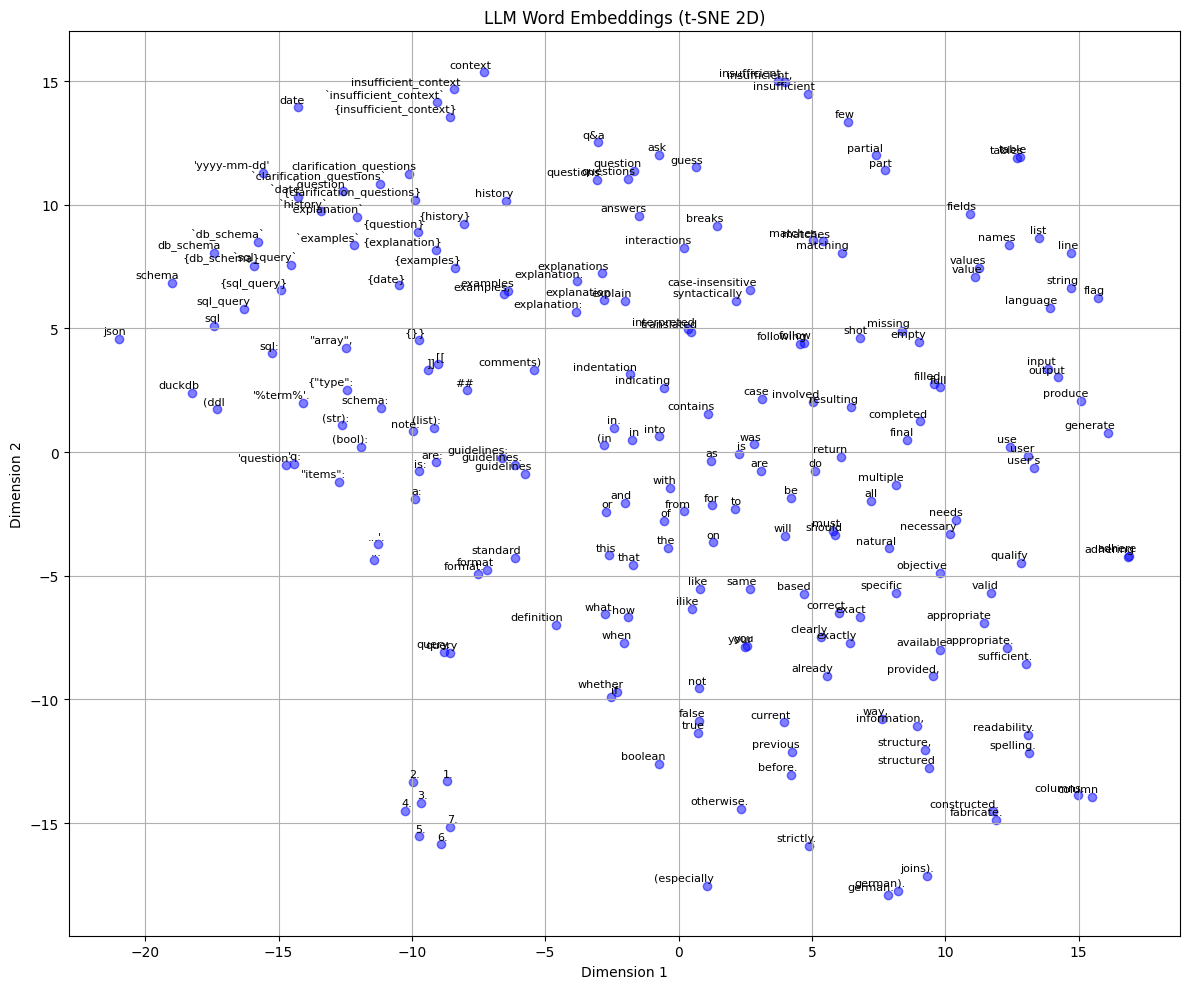

Erstelle Token-Level Visualisierungen...


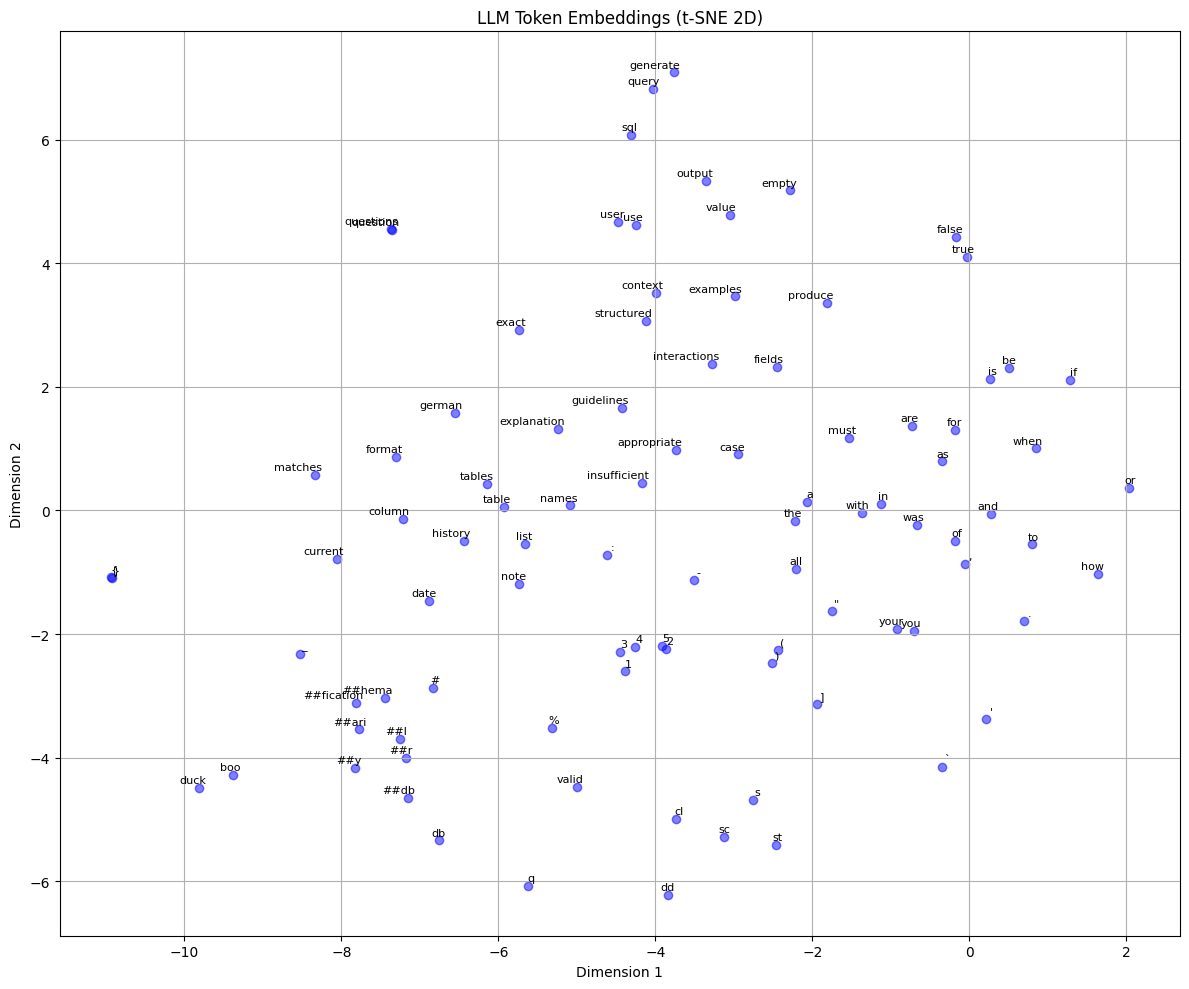

Erstelle Sentence-Level Visualisierungen...
Zeige interaktive Plots...


In [15]:
# Beispieltext (kann durch deinen Text ersetzt werden)
sample_text = """
Large Language Models (LLMs) haben die Art und Weise revolutioniert, wie wir mit Sprache interagieren.
Diese Modelle werden auf riesigen Textmengen trainiert und können natürliche Sprache verstehen und generieren.
Moderne LLMs wie GPT, BERT und T5 nutzen komplexe Transformer-Architekturen.
Die Transformer-Architektur basiert auf Selbstaufmerksamkeitsmechanismen, die es dem Modell ermöglichen, Beziehungen zwischen Wörtern zu erfassen.
Tokenisierung ist ein wichtiger erster Schritt in der NLP-Pipeline. Tokens können Wörter, Teilwörter oder einzelne Zeichen sein.
Word Embeddings sind numerische Repräsentationen von Wörtern im hochdimensionalen Raum.
Semantisch ähnliche Wörter liegen im Embedding-Raum oft nahe beieinander.
Die Visualisierung von Embeddings kann Einblicke in die semantischen Beziehungen zwischen Wörtern geben.
Dimensionsreduktionsverfahren wie t-SNE und PCA werden häufig verwendet, um hochdimensionale Embeddings in 2D oder 3D darzustellen.
"""

sample_text ="""
Tabelle: products
Beschreibung: Zentrale Tabelle für die individuelle Rückverfolgbarkeit von Motoren und deren Komponenten. Jeder Datensatz verknüpft ein spezifisches Bauteil (Individuum) mit einem bestimmten Motor. 
Diese Tabelle wird verwendet, wenn die exakte Zuordnung wichtig ist - also welche spezifische Komponente in welchem spezifischen Motor verbaut wurde.
<Dataset products>

Column: productnumber
DataType: VARCHAR
Example values:
- YFPD653244374001
- YFT5630148901001
- YFT5630099402001
- YFR6610851916003
- YFPD653244374004
- YFPD653244374022

Description: Produktnummer des Motors. Wenn sie mit YF beginnt wurde der Motor in Bad Neustadt hergestellt. Beginnt sie mit IR wurde der Motor in Buzias hergestellt.
Common names: 
- Produktnummer
- Seriennummer
- Serialnummer
- Fabrikate Nummer

"""

sample_text = """

Your input fields are:
1. `db_schema` (str): Full schema definition (DDL + comments) of the available DuckDB tables and columns.
2. `date` (str): Current date in 'YYYY-MM-DD' format.
3. `examples` (str): Few Shot Examples structured as 'Question: ... Explanation: ... SQL: ...'.
4. `history` (str): List of previous Q&A interactions in the format 'Q: ... A: ...'.
5. `question` (str): The user's current natural language query to be translated into SQL with explanation.
Your output fields are:
1. `explanation` (str): Explanation of how the query was interpreted and how the resulting SQL query was constructed. The explanation needs to be German.
2. `sql_query` (str): The final DuckDB SQL query that answers the user's question based on the schema and guidelines. Should be empty if context is insufficient.
3. `insufficient_context` (bool): Boolean flag indicating whether the context is insufficient to generate a valid SQL query. True if context is insufficient, False otherwise.
4. `clarification_questions` (list): List of specific questions to ask the user when context is insufficient (in german). Empty list if context is sufficient.
All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## db_schema ## ]]
{db_schema}

[[ ## date ## ]]
{date}

[[ ## examples ## ]]
{examples}

[[ ## history ## ]]
{history}

[[ ## question ## ]]
{question}

[[ ## explanation ## ]]
{explanation}

[[ ## sql_query ## ]]
{sql_query}

[[ ## insufficient_context ## ]]
{insufficient_context}        # note: the value you produce must be True or False

[[ ## clarification_questions ## ]]
{clarification_questions}        # note: the value you produce must adhere to the JSON schema: {"type": "array", "items": {}}

[[ ## completed ## ]]
In adhering to this structure, your objective is: 
        Generate valid DuckDB SQL from user questions. Explanations in German. Follow guidelines strictly.
        Guidelines:
        1. If the context contains all necessary information, generate a syntactically correct DuckDB SQL query.
        2. If the context is insufficient, clearly explain what is missing and do not guess or fabricate.
        3. If the exact question is already part of the examples, return the exact same SQL output as before.
        4. Use table and column names exactly as provided, matching case and spelling.
        5. Qualify column names with table names when multiple tables are involved (especially joins).
        6. For partial string matches, use LIKE '%term%'. Use ILIKE for case-insensitive matches if appropriate.
        7. Format the SQL with standard indentation and line breaks for readability.
"""
# ###

# Column: productionordernumber
# DataType: BIGINT
# Example values:
# - 53640502
# - 35884135
# - 36329260
# - 36341794
# - 53386697

# Description: Fertigungsauftrag für eine Prozessebene, Referenz auf sap.afko_lead_aufnr (Führende Auftragsnummer in sap), 8-stellig. Beginnt eine Fertigungsauftragsnummer mit 5 ist es ein anonymes Produkt, 
# das nicht zu einem Kundenauftrags gefertigt worden ist, beginnt es mit einer 3 dann wurde es zu einem Kundenauftrag spezifisch gefertigt.
# Common names:
# - Produktionsauftrag
# - Fertigungsauftragsnummer

# ###

# Column: customerordernumber
# DataType: BIGINT
# Example values:
# - 300681
# - 298378
# - 100041
# - 200000
# - 34033
# - 407842
# - 600718

# Description: Kundenauftragsnummer, 6-stellig. Kann NULL sein. Ist Teil der Serialnummer -> Kundenauftragsnummer 300681 steckt in Serialnummer YFT5630068101001 an 6. bis 11. Stelle.
# Common names:
# - Kundenauftragsnummer

# ###

# Column: customerorderpositionnumber
# DataType: BIGINT
# Example values:
# - 1
# - 4
# - 15
# - 35
# - 85
# - 54
# - 64
# - 62

# Description: Kundenauftragspositionsnummer. Kann NULL sein. Ist Teil der Serialnummer -> Kundenauftragspositionsnummer 1 steckt in Serialnummer YFT5630068101001 an 12. & 13. Stelle (01).
# Common names:
# - Kundenauftragspositionsnummer

# ###

# Column: genealogydata_assembleddatetime
# DataType: VARCHAR
# Example values:
# - 2023-10-19 11:30:21
# - 2025-05-28 07:32:53
# - 2022-11-30 05:35:02
# - 2023-06-27 10:54:46
# - 2024-01-04 05:10:02
# - 2025-01-07 05:12:52

# Description: Zeitstempel wann die Trace Komponente in der Fertigung erfasst worden ist im Format 'YYYY-MM-DD HH:MM:SS'.
# Common names:
# - Zeitpunkt
# - Montagezeitpunkt
# ###

# Column: genealogydata_materialnumber
# DataType: VARCHAR
# Example values:
# - A5E50757302002
# - M40002889665
# - 000005192254587000
# - 000006883706356000
# - M40000960613
# - A5E51097477008
# - A5E41578267802

# Description: Für Trace Typen 1 bis 4 ist es die Materialnummer der Komponente, bei Trace Typ 5 ist es die Materialnummer der Baugruppe aber nicht der Einzelteile.
# Common names:
# - Materialnummer

# ###

# Column: genealogydata_genealogytracetype
# DataType: BIGINT
# All available values:
# - 1
# - 2
# - 3
# - 4
# - 5
# - 10

# Description: Art der Rückverfolgbarkeit. Mögliche Werte -> 1=Charge, 2=Charge, 3=???, 4=Unikat, 5=(Standardkomponente, Baugruppe), 10=Sonderbehandlung.
# Common names:
# - Trace Typ

# ###

# Column: genealogydata_tracedata
# DataType: VARCHAR
# Example values:
# - 709246/253
# - YFT6653654782015
# - 1P5194021653+S2508001895
# - 25150007FI
# - +KS11006A02_0001_NEU+0-016012A+000000000590691/22B+
# - 10897721
# - K2000085219
# - M0324131030203541
# - ZZLT5/8319073601

# Description: Inhalt vom Barcode Scan. Eigengefertigte Komponenten fangen mit einem YF an, Bremsen z.B. enden mit einem / worauf das Jahr z.B. 25 für 2025 und der Monat z.B. 3 folgen. 
# Für diese Spalte lassen sich jedoch keine festen Regeln aufstellen, da die Vielfalt sehr hoch ist und teilweise von Lieferantenbezeichnungen abhängt.
# Common names:
# - Trace-Daten
# - Trace Informationen
# - Barcode
# - DMC

# ###

# Column: referencedproductionorders_productionordernumber
# DataType: BIGINT
# Example values:
# - 53400622
# - 53647621
# - 53391563
# - 35865830
# - 35811184
# - 35822870

# Description: Referenz auf orders.productionordernumber. Kann NULL sein, ist in der Regel bei Trace Typ 5 befüllt.

# ###

# Column: referencedproductionorders_deliverydate
# DataType: VARCHAR
# Example values:
# - 2023-11-15 08:45:32
# - 2024-08-15 16:54:23
# - 2025-02-20 14:30:00

# Description: Lieferdatum im Format 'YYYY-MM-DD HH:MM:SS'.

# ###

# Column: year
# DataType: BIGINT
# Example values:
# - 2023
# - 2024
# - 2025

# Description: Jahr der Erfassung.

# ###

# Column: month
# DataType: BIGINT
# Example values:
# - 1
# - 6
# - 12

# Description: Monat der Erfassung (z.B. 1 für Januar).

# </Dataset products>
# Tabelle: orders
# Beschreibung: Erfasst Trace-Daten von Komponenten, bei denen keine individuelle Zuordnung erforderlich ist (hauptsächlich Trace Typ 5 in products.genealogydata_genealogytracetype). 
# Beispiel: Bei 40 gleichartigen Bremsen wird nur geprüft, ob der richtige Bremsentyp für den Fertigungsauftrag verwendet wird, aber nicht welche spezifische Bremse an welchem Motor verbaut wurde. 
# Hauptsächlich für Chargen-basierte Rückverfolgung.
# <Dataset orders>

# Column: productionordernumber
# DataType: BIGINT
# Example values:
# - 53640502
# - 53647621
# - 35865830

# Description: Fertigungsauftragsnummer, siehe products.productionordernumber. Unterschied: hier kommen nur Fertigungsauftragsnummern vor, die mit 5 beginnen (anonyme Produkte, die nicht zu einem Kundenauftrag gefertigt wurden).

# ###

# Column: genealogydata_assembleddatetime
# DataType: VARCHAR
# Example values:
# - 2023-10-19 11:30:21
# - 2025-05-28 07:32:53

# Description: Zeitstempel wann die Trace Komponente in der Fertigung erfasst worden ist im Format 'YYYY-MM-DD HH:MM:SS'. Siehe products.genealogydata_assembleddatetime.

# ###

# Column: genealogydata_materialnumber
# DataType: VARCHAR
# Example values:
# - A5E50757302002
# - M40002889665
# - 000005192254587000

# Description: Materialnummer der Komponente. Für Trace Typen 2 und 4 ist es die Materialnummer der Komponente. Siehe products.genealogydata_materialnumber.

# ###

# Column: genealogydata_genealogytracetype
# DataType: BIGINT
# All available values:
# - 2
# - 4

# Description: Art der Rückverfolgbarkeit. Siehe products.genealogydata_genealogytracetype. Unterschied: hier kommen nur Trace Typen 2 (Charge) und 4 (Unikat) vor.

# ###

# Column: genealogydata_tracedata
# DataType: VARCHAR
# Example values:
# - 709246/253
# - YFT6653654782015
# - 1P5194021653+S2508001895
# - 25150007FI

# Description: Inhalt vom Barcode Scan. Eigengefertigte Komponenten fangen mit einem YF an, Bremsen z.B. enden mit einem / worauf das Jahr z.B. 25 für 2025 und der Monat z.B. 3 folgen. Siehe products.genealogydata_tracedata.

# ###

# Column: year
# DataType: BIGINT
# Example values:
# - 2023
# - 2024
# - 2025

# Description: Jahr der Erfassung.

# ###

# Column: month
# DataType: BIGINT
# Example values:
# - 1
# - 6
# - 12

# Description: Monat der Erfassung (z.B. 1 für Januar).

# </Dataset orders>

# Tabelle: sap
# Beschreibung: Grundlegende ERP-Datenbasis, die als Ausgangspunkt für alle Fertigungsprozesse dient. 
# Diese Tabelle enthält die Rohdaten aus SAP, die für die Bestimmung der Trace-Relevanz und die Steuerung der Fertigungsaufträge benötigt werden. 
# afko_* → Fertigungsaufträge
# afpo_* → Kundenauftragsbezug (Werk, Kundenauftrag, Position)
# makt_* → Materialkurztexte (Produktionsdaten)
# mara_* → Materialstamm (Kennzeichen)
# resb_* → Reservierungen für Komponenten
# vbap_* → Kundenauftragsdaten (z.B. MLFB, Fabrikgruppe, Zusatzoptionen)
# <Dataset sap>

# Column: afko_aufnr
# DataType: BIGINT
# Example values:
# - 53640502
# - 35884135
# - 36229169
# - 35927626
# - 53413394
# - 53413360

# Description: Fertigungsauftragsnummer, siehe products.productionordernumber.

# ###

# Column: afko_fevor
# DataType: VARCHAR
# Example values:
# - L02
# - MA1
# - M16
# - PSC
# - RM2
# - MWB
# - K02
# - KOL
# - SAA
# - P07
# - GM1

# Description: Identifikation der Auftragsebene. Naming Convention Anfangsbuchstabe = Prozess: P = Verpacken, L = Läuferauftrag, W = Wickeln, M = Montage, A = Anbau. 
# Common names: 
# - Fertigungssteuerer

# ###

# Column: afko_gamng
# DataType: DOUBLE
# Example values:
# - 1
# - 5
# - 15
# - 20
# - 408
# - 816
# - 34

# Description: Gesamtmenge des Auftrags. 
# Common names: 
# - Auftragsmenge
# - Fertigungsauftragsmenge

# ###

# Column: afko_getri
# DataType: BIGINT
# Example values:
# - 20250123
# - 20230118

# Description: Ist-Endtermin im Format YYYYMMDD. Eher unwichtige Spalte.

# ###

# Column: afko_getri_timestamp
# DataType: VARCHAR
# Example values:
# - 2025-01-23 00:00:00
# - 2023-08-30 00:00:00

# Description: Ist-Endtermin im Format YYYY-MM-DD HH:MM:SS. 
# Common names: 
# - Zeitpunkt
# - Ist-Endtermin.

# ###

# Column: afko_gltri
# DataType: BIGINT
# Example values:
# - 20250506
# - 20231004

# Description: Liefertermin im Format YYYYMMDD.
# Common names: 
# - Liefertermin

# ###

# Column: afko_gltrs
# DataType: BIGINT
# Example values:
# - 20250507

# Description: Geschätzter Endtermin im Format YYYYMMDD. 
# Common names: 
# - Endtermin

# ###

# Column: afko_lead_aufnr
# DataType: BIGINT
# Example values:
# - 35513358
# - 36433126
# - 35513358
# - 53386640
# - 160000000467
# - 160000000490

# Description: Referenziert den übergeordneten Fertigungsauftrag in der Auftragshierarchie. Bei mehrstufigen Fertigungsprozessen gibt es Unteraufträge (z.B. für Läufer, Wicklung, Montage), die alle auf einen führenden Auftrag verweisen. 
# Common names: 
# - Führende Auftragsnummer

# ###

# Column: afko_plnbez
# DataType: VARCHAR
# Example values:
# - M1100538810
# - FT713_MONT
# - A5E50969071001
# - 000002183750801300
# - M40000830511
# - A5E44476633002
# - 000002183330801300
# - A5E51292110003

# Description: Materialnummer
# Common names: 
# - Materialnummer

# ###

# Column: afko_zzfabnr
# DataType: VARCHAR
# Example values:
# - T1653 2190 01 001
# - T4653 7391 04 001
# - S7653 5164 75 001
# - S6653 5166 49 001
# - A7312 1121 01 001
# - B627 7834 01 018
# - C351 0764 88 002
# - DN695 0080 37 001
# - E3648 0828 01 001
# - H1623 8152 02 001

# Description: Die erste Serialnummer des zugehörigen Fertigungsauftrags. 
# Common names: 
# - Fabriknummer

# ###

# Column: afpo_dwerk
# DataType: VARCHAR
# All available values:
# - 2301
# - C501

# Description: Werksidentifikation. 2301 = Bad Neustadt, C501 = Buzias. 
# Common names: 
# - Werk
# - Standort

# ###

# Column: afpo_kdauf
# DataType: BIGINT
# Example values:
# - 300681
# - 298378
# - 100012
# - 29481
# - 32176
# - 402266
# - 513626
# - 600664

# Description: Kundenauftragsnummer, siehe products.customerordernumber.

# ###

# Column: afpo_kdpos
# DataType: SMALLINT
# Example values:
# - 480
# - 440
# - 97
# - 25
# - 21
# - 100
# - 87

# Description: Kundenauftragspositionsnummer, siehe products.customerorderpositionnumber.

# ###

# Column: afko_system
# DataType: VARCHAR
# All available values:
# - R2P01
# - S4P01

# Description: Identifiziert das Quellsystem, aus dem die Fertigungsauftragsdaten stammen. Aktuell sind 'R2P01' & 'S4P01' die einzigen verwendeten Werte, kann auch NULL sein. Eher unwichtige Spalte.

# ###

# Column: makt_maktx
# DataType: VARCHAR
# Example values:
# - DAUERMAGNET 1FT510.
# - LTG 2,5X165 N4GAF RD
# - Huelse 1FE2114-8
# - P-SCHEIBE-DIN988-37X47X0,5
# - F-SCHEIBE 37x45x0,5
# - Lagerschild AS 1FT706 mBr Flan.1 bearb.
# - O-RING 100X2 FPM, 75 SHORE A
# - ZY-SCHR-SN60056-UM5X60-ST-DT-F
# - Platt vollst. Prozessoptimiert
# - ZY-SCHR-ISO14579-M5X20-8.8-A2B-OT85
# - GLEITMO.800
# - USIT-SCHEIBE UA5.2x8.7x1
# - 1FK7063-2AF7 PT1 SB VW

# Description: Materialbeschreibung in Textform. 
# Common names: 
# - Materialkurztext
# - Materialbeschreibung

# ###

# Column: mara_zzkenn
# DataType: VARCHAR
# Example values:
# - K324
# - N534
# - K031
# - N231
# - K030
# - N212
# - K165
# - N559
# - K187
# - K057

# Description: Historisches Klassifizierungssystem für Materialien, das auch nach der SAP-Einführung beibehalten wurde. 
# Der Buchstabe gefolgt von einer dreistelligen Zahl identifiziert eindeutig die Art des Materials. Wichtige Kennziffern sind z.B.: 
# K057 = Stator, K688 = Rotor komplett verbaut, K384 = Läufer, K129 = Lagerschild, K519 = Bremse oder Geber, K529 = Getriebe. 
# Wenn nach Rotoren gefragt wird filtere sowohl nach K688 als auch nach K384. Diese Kennzeichnung wurde eingeführt, als die alten Materialnummern 
# durch SAP-konforme A5E-Nummern ersetzt wurden, um die schnelle Identifikation von Materialtypen weiterhin zu ermöglichen. 
# Common names:
# - Materialkennzeichen
# - Kennziffer

# ###

# Column: resb_bdmng
# DataType: DOUBLE
# Example values:
# - 0.45
# - 15
# - 18
# - 10
# - 40
# - 0.009999999776482582

# Description: Gibt an, wie viele Einheiten einer Komponente benötigt werden. Bei Standardteilen wie Schrauben können dies mehrere Stück sein (z.B. 15 ST), bei Materialien wie Kupferdraht wird nach Gewicht gerechnet (z.B. 0.45 KG). Die Menge muss immer im Kontext mit der Mengeneinheit (resb_meins) betrachtet werden. 
# Common names:
# - Bedarfsmenge
# - Komponenten-Menge

# ###

# Column: resb_matnr
# DataType: VARCHAR
# Example values:
# - A5E50757302002
# - M40002889665
# - 000005192254587000

# Description: Materialnummer der Komponente, siehe products.genealogydata_materialnumber. Unterschied: es kommen führende Nullen mit vor.

# ###

# Column: resb_meins
# DataType: VARCHAR
# All available values:
# - G
# - M
# - L
# - M2
# - KG
# - ST

# Description: Definiert die Einheit der Bedarfsmenge. Mögliche Werte sind:
# - ST = Stück (für Einzelteile wie Schrauben, Lager)
# - KG = Kilogramm (für Gewichtsmaterialien wie Kupfer)
# - G = Gramm (für kleinere Gewichtsmengen)
# - M = Meter (für Längenware wie Kabel, Isolierschläuche)
# - M2 = Quadratmeter (für Flächenmaterialien wie Isolierpapier)
# - L = Liter (für Flüssigkeiten wie Lack, Öl)
# Common names:
# - Mengeneinheit
# - Maßeinheit

# ###

# Column: resb_posnr
# DataType: VARCHAR
# Example values:
# - 3500
# - 2249
# - 1140
# - 0388
# - 0375
# - 0350
# - 7067
# - 3901
# - 1100
# - 1200
# - 3000

# Description: Position der Komponente in der Stückliste des Motors. Es existieren gewisse Konventionen, die aber nicht so zuverlässig sind wie die Materialkennzeichen (mara_zzkenn). Häufige Positionen sind:
# - 1100: typischerweise für Stator
# - 1200: typischerweise für Rotor
# - 3000: typischerweise für Lagerschild
# Die Positionsnummern dienen der strukturierten Anordnung der Komponenten in der Stückliste, sind aber weniger strikt standardisiert als die Materialkennzeichen. 
# Common names: 
# - Stücklistenposition
# - Positionsnummer

# ###

# Column: resb_potx1
# DataType: VARCHAR
# Example values:
# - MAGNETE
# - KL_KA_OBERTEIL
# - FE1_MAGNET
# - PH4_LAGERSCH_BS
# - 1FK21056A++++++0
# - Längsleisten Stator
# - BREMSE_MODUL_GEH
# - LAGERSCHILD SCHRAUBE AS

# Description: Kurztext MLFB der Komponente, eher unwichtige Spalte.

# ###

# Column: vbap_yybcezndr
# DataType: VARCHAR
# Example values:
# - 1FE2116-8CJ12-2DW1
# - EWN:0573002402490
# - 1FT7136-5AB71-1BH0
# - 1FW3150-1MH62-7DA0-Z
# - 1FK2106-4AF00-1SA0
# - 1FK2208-4AC10-1MB0
# - 1FK7064-7AF71-1SA0
# - 1PH2118-6WF22
# - 1FW6190-0VB05-1JA3-Z

# Description: Standardisierte Produktkennzeichnung für Siemens-Motoren. 
# Common names: 
# - MLFB
# - Maschinenlesbare
# - Fabrikatebezeichnung

# ###

# Column: vbap_yybcvfgrp
# DataType: VARCHAR
# Example values:
# - 9638
# - 5691
# - 9693
# - X0II
# - 9328
# - 5690
# - 9621
# - 5683
# – X0OV

# Description: Vierstelliger Code zur Klassifizierung von Motortypen in Produktfamilien. Die Gruppierung basiert auf der MLFB-Bezeichnung und clustert ähnliche Motoren zusammen. 
# Common names:
# - Fabrikgruppe
# - Vertriebsfabrikategruppe.

# ###

# Column: vbap_yykurzanga
# DataType: VARCHAR
# Example values:
# - K23M39Y84
# - N01N05R2A
# - X53
# - D23E10G23G97K07N23Q91W90Y84
# – D01G23K07N23X05Y84
# - D01G23K07N23Q92
# - S77
# - K1AK23X53Y84
# - X08
# - U60V90Y84

# Description: Enthält kundenspezifische Zusatzoptionen, die über die Standard-MLFB hinausgehen. Diese Z-Optionen werden verwendet, wenn die 16-stellige MLFB nicht ausreicht, um alle Spezifikationen abzubilden. 
# Anwendungsfälle:
# - Getriebeausführungen
# - Sonderausführungen
# - Spezielle Kundenanforderungen
# Common names:
# - Z-Optionen
# - Zusatzoptionen
# - Kurzangaben

# ###

# Column: year
# DataType: BIGINT
# Example values:
# - 2023
# - 2024
# - 2025

# Description: Jahr der Datensatzerstellung.

# ###

# Column: month
# DataType: BIGINT
# Example values:
# - 1
# - 6
# - 12

# Description: Monat der Datensatzerstellung (z.B. 1 für Januar).

# </Dataset sap>

# Tabelle: results
# Beschreibung: Konsolidierte Ergebnistabelle zur vereinfachten Rückverfolgbarkeit von Motoren und deren Komponenten. 
# Aggregiert relevante Informationen aus SAP-, Produktions- und Auftragsdaten zur schnellen Auffindbarkeit und Analyse von Trace-Daten.
# <Dataset results>

# Column: FAUF
# DataType: BIGINT
# Example values:
# - 53640502
# - 35884135
# - 35752447
# - 35752484
# - 35753375

# Description: Fertigungsauftragsnummer (Referenz auf sap.afko_aufnr).

# ###

# Column: Zeitstempel_sap
# DataType: TIMESTAMP
# Example values:
# - 2023-10-19 11:30:21
# - 2025-05-28 07:32:53

# Description: Ist-Endtermin SAP im Format 'YYYY-MM-DD HH:MM:SS'.

# ###

# Column: Kurztext
# DataType: VARCHAR
# Example values:
# - Geh vollst 1FK2210-4AF
# - 1FT7086-5AF7 OIS PT1
# - Ständer (geschaltet) 1FW6190-8..05-1J.3
# - 1FT7105-5WC7 oIS PT1
# - Geh vollst 1FK2104-5AK
# - 1FT7108-5AB7 MIS PT1
# - LFR MONT 1FK2208-5 mBr mPf IP64
# - Resolver vollst. SIZE 21 - 8-polig  M23
# - Geh vollst 1FK2206-4AF

# Description: Materialbeschreibung (Referenz SAP makt_maktx).

# ###

# Column: MARA_ZZKENN
# DataType: VARCHAR
# Example values:
# - K324
# - N534
# - K031
# - K187
# - K057

# Description: Materialkennzeichen (Referenz SAP mara_zzkenn).

# ###

# Column: Materialnummer
# DataType: VARCHAR
# Example values:
# - A5E50757302002
# - M40002889665
# - 000005192254587000

# Description: SAP Materialnummer (Referenz SAP resb_matnr).

# ###

# Column: SL_POS
# DataType: VARCHAR
# Example values:
# - 0070
# - 3999
# - 3550
# - 5020
# - 5000
# - 1200
# - 3500
# - 3000
# - 1100
# - 6520

# Description: Stücklistenposition der Komponente (SAP resb_posnr, z.B. '6520' für Bremse).

# ###

# Column: MLFB
# DataType: VARCHAR
# Example values:
# - 1FE2116-8CJ12-2DW1
# - EWN:0573002402490
# - 1FT7136-5AB71-1BH0

# Description: MLFB (Maschinenlesbare Fabrikatebezeichnung, SAP vbap_yybcezndr).

# ###

# Column: Kurzangabe
# DataType: VARCHAR
# Example values:
# - K23M39Y84
# - N01N05R2A
# - X53

# Description: Kunden-spezifizierte Zusatzoption/Z-Option (SAP vbap_yykurzanga).

# ###

# Column: Barcode
# DataType: VARCHAR
# Example values:
# - 709246/253
# - YFT6653654782015
# - 1P5194021653+S2508001895
# - 25150007FI

# Description: Trace-Daten aus Barcode oder DMC-Scan (Referenz products.genealogydata_tracedata).

# ###

# Column: Serialnummer
# DataType: VARCHAR
# Example values:
# - YFPD653244374001
# - YFT5630148901001
# - YFT5630099402001

# Description: Seriennummer Motor oder Komponente (Referenz products.productnumber).

# ###

# Column: KD_AUFNR
# DataType: INTEGER
# Example values:
# - 300681
# - 298378

# Description: Kundenauftragsnummer (Referenz products.customerordernumber).

# ###

# Column: KD_POS
# DataType: SMALLINT
# Example values:
# - 1
# - 4
# - 15

# Description: Kundenauftragspositionsnummer (Referenz products.customerorderpositionnumber).

# ###

# Column: Laufer_FAUF
# DataType: INTEGER
# Example values:
# - 53400622
# - 53647621

# Description: Referenzierte Läufer-Auftragsnummer (products.referencedproductionorders_productionordernumber).

# ###

# Column: Zeitstempel
# DataType: TIMESTAMP
# Example values:
# - 2023-10-19 11:30:21
# - 2025-05-28 07:32:53

# Description: Zeitstempel der Montage aus Products (products.genealogydata_assembleddatetime).

# ###

# Column: Trace_Typ
# DataType: SMALLINT
# All available values:
# - 1
# - 2
# - 3
# - 4
# - 5
# - 10

# Description: Trace-Typ der Komponente (products.genealogydata_genealogytracetype).

# ###

# Column: Materialnummer_Komponente
# DataType: VARCHAR
# Example values:
# - A5E50757302002
# - M40002889665
# - 000005192254587000

# Description: Materialnummer Komponente aus Orders (orders.genealogydata_materialnumber).

# ###

# Column: Ist_Bremse
# DataType: BOOLEAN
# All available values:
# - true
# - false

# Description: Flag: Ist Komponente eine Bremse.

# ###

# Column: query_name
# DataType: VARCHAR
# All available values:
# - base
# - sl_pos_6520
# - tt_10

# Description: Ursprungsquery-Identifikator ('base', 'sl_pos_6520' oder 'tt_10').

# ###

# Column: year
# DataType: INTEGER
# Example values:
# - 2023
# - 2024
# - 2025

# Description: Jahr der Datenerfassung.

# ###

# Column: month
# DataType: INTEGER
# Example values:
# - 1
# - 6
# - 12

# Description: Monat der Datenerfassung (z.B. 1 für Januar).

# </Dataset results>

# TABELLENBEZIEHUNGEN:

# 1. orders ↔ products  
#    Kardinalität: n : m  (0..n ↔ 0..n)  
#    – In orders gibt es Dubletten; in products Datensätze ohne passenden orders-Eintrag.  
#    Join-Felder:  
#      products.referencedproductionorders_productionordernumber = orders.productionordernumber  
#      products.genealogydata_tracedata = orders.genealogydata_tracedata  
  
# 2. sap ↔ orders  
#    Kardinalität: n : m  (0..n ↔ 0..n)  
#    – Mehrere Stücklistenzeilen pro Auftrag in sap, mehrere Barcode-Scans pro Auftrag in orders.
#    Join-Feld:  
#      orders.productionordernumber = sap.afko_aufnr  
  
# 3. sap ↔ products  
#    Kardinalität: n : m  (0..n ↔ 0..n)  
#    – Mehrere BOM-Zeilen je Auftrag treffen auf mehrere Einbauvorgänge in products.
#    Join-Felder:  
#      SUBSTRING(CONCAT('YF', REPLACE(sap.afko_zzfabnr,' ','')), 1, 13) = SUBSTRING(products.productnumber, 1, 13)  
#      sap.resb_matnr = products.genealogydata_materialnumber  
  
# 4. results Tabelle:
# - Konsolidierte Sicht aus allen drei Tabellen
# - Wird durch drei verschiedene Queries befüllt:
#   * base: Grundlegende Komponenten
#   * sl_pos_6520: Spezifisch für Bremsen
#   * tt_10: Komponenten mit Sonderbehandlung

# Nutze primär die results Tabelle, wenn nicht explizit nach Daten aus den 3 Roh-Tabellen products, orders & sap gefragt wird. 
# Für deine Bachelorarbeit kannst du hier deinen eigenen Text einfügen
# Beispiel: mit Text aus einer Datei
# with open('mein_text.txt', 'r', encoding='utf-8') as file:
#     sample_text = file.read()

# Du kannst verschiedene Embedding-Modelle ausprobieren:
# - "sentence-transformers/all-mpnet-base-v2" (sehr gute Qualität, etwas langsamer)
# - "sentence-transformers/all-MiniLM-L6-v2" (guter Kompromiss aus Geschwindigkeit und Qualität)
# - "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2" (mehrsprachig, gut für Deutsch)

# Visualisierung ausführen
results = visualize_llm_embeddings(
    sample_text, 
    # embedding_model="sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # Gut für deutsche Texte
    embedding_model="intfloat/multilingual-e5-large"
)

In [13]:
def export_results(results, filename_prefix="llm_embedding_results"):
    """
    Exportiert die Ergebnisse in CSV-Dateien zur weiteren Verwendung in der Bachelorarbeit
    """
    # Word-Level Embeddings
    word_df = pd.DataFrame({
        'word': results["words"],
        'tsne_2d_x': results["word_tsne_2d"][:, 0],
        'tsne_2d_y': results["word_tsne_2d"][:, 1],
        'tsne_3d_x': results["word_tsne_3d"][:, 0],
        'tsne_3d_y': results["word_tsne_3d"][:, 1],
        'tsne_3d_z': results["word_tsne_3d"][:, 2],
        'pca_2d_x': results["word_pca_2d"][:, 0],
        'pca_2d_y': results["word_pca_2d"][:, 1]
    })
    
    # Token-Level Embeddings
    token_df = pd.DataFrame({
        'token': results["tokens"],
        'tsne_2d_x': results["token_tsne_2d"][:, 0],
        'tsne_2d_y': results["token_tsne_2d"][:, 1],
        'tsne_3d_x': results["token_tsne_3d"][:, 0],
        'tsne_3d_y': results["token_tsne_3d"][:, 1],
        'tsne_3d_z': results["token_tsne_3d"][:, 2],
        'pca_2d_x': results["token_pca_2d"][:, 0],
        'pca_2d_y': results["token_pca_2d"][:, 1]
    })
    
    # Sentence-Level Embeddings
    short_sentences = [s[:100] + "..." if len(s) > 100 else s for s in results["sentences"]]
    sentence_df = pd.DataFrame({
        'sentence': short_sentences,
        'tsne_2d_x': results["sent_tsne_2d"][:, 0],
        'tsne_2d_y': results["sent_tsne_2d"][:, 1],
        'tsne_3d_x': results["sent_tsne_3d"][:, 0],
        'tsne_3d_y': results["sent_tsne_3d"][:, 1],
        'tsne_3d_z': results["sent_tsne_3d"][:, 2],
        'pca_2d_x': results["sent_pca_2d"][:, 0],
        'pca_2d_y': results["sent_pca_2d"][:, 1]
    })
    
    # CSV-Dateien speichern
    word_df.to_csv(f"{filename_prefix}_words.csv", index=False)
    token_df.to_csv(f"{filename_prefix}_tokens.csv", index=False)
    sentence_df.to_csv(f"{filename_prefix}_sentences.csv", index=False)
    
    print(f"Ergebnisse wurden in CSV-Dateien gespeichert:\n"
          f"- {filename_prefix}_words.csv\n"
          f"- {filename_prefix}_tokens.csv\n"
          f"- {filename_prefix}_sentences.csv")

# Ergebnisse exportieren
export_results(results, "ba_llm_visualisierung")

Ergebnisse wurden in CSV-Dateien gespeichert:
- ba_llm_visualisierung_words.csv
- ba_llm_visualisierung_tokens.csv
- ba_llm_visualisierung_sentences.csv


In [19]:
# Python code to get and print an embedding
from sentence_transformers import SentenceTransformer

# Load model
model = SentenceTransformer("intfloat/multilingual-e5-large")

# Get embedding for "sql"
sql_embedding = model.encode(["sql"])[0]
sql_embedding2 = model.encode(["query"])[0]
sql_embedding3 = model.encode(["database"])[0]

# Print LaTeX representation
print("\\begin{align}")
print("\\mathbf{v}_{\\text{sql}} = ")
print("\\begin{bmatrix}")

# Print first 8 values
print(" & ".join([f"{val:.6f}" for val in sql_embedding[:8]]) + " & \\cdots")

print("\\end{bmatrix}^T \\in \\mathbb{R}^{" + str(len(sql_embedding)) + "}")
print("\\end{align}")

\begin{align}
\mathbf{v}_{\text{sql}} = 
\begin{bmatrix}
0.014788 & 0.025825 & -0.033831 & -0.043754 & 0.010651 & -0.025145 & -0.011005 & 0.023248 & \cdots
\end{bmatrix}^T \in \mathbb{R}^{1024}
\end{align}


In [20]:
sql_embedding

array([ 0.01478808,  0.02582529, -0.03383067, ...,  0.01885418,
        0.00664132,  0.02448627], shape=(1024,), dtype=float32)

In [21]:
sql_embedding2

array([ 0.02005542,  0.00013358, -0.01567621, ..., -0.02874693,
       -0.04286381,  0.01751361], shape=(1024,), dtype=float32)

In [22]:
sql_embedding3

array([ 0.04682398,  0.02450395, -0.03262337, ...,  0.02794292,
       -0.01232731,  0.01459344], shape=(1024,), dtype=float32)